In [1]:
import time
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from scipy.sparse import csr_array

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import graspologic

In [2]:
# reading data
df_features = pd.read_csv("./elliptic/elliptic_txs_features.csv", header=None)
df_classes= pd.read_csv("./elliptic/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./elliptic/elliptic_txs_edgelist.csv")

In [3]:
g = nx.from_pandas_edgelist(
    df_edgelist,
    source="txId1",
    target="txId2",
    create_using=nx.DiGraph,
)

In [31]:
# finds largest connected component and spits that out
g = graspologic.utils.largest_connected_component(g)

In [32]:
nodelist = list(g.nodes)
adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

In [45]:
from graspologic.partition import leiden

currtime = time.time()
sym_adj = adj + adj.T
out = leiden(sym_adj, resolution = 0.0000000000000000000000000000000000000000001)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

0.361 seconds elapsed.


In [57]:
def symmetrze_nx(g):
    """Leiden requires a symmetric/undirected graph. This converts a directed graph to
    undirected just for this community detection step"""
    sym_g = g.to_undirected()
    return sym_g


currtime = time.time()
sym_g = symmetrze_nx(g)
out2 = leiden(sym_g)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

0.068 seconds elapsed.


In [58]:
node_df = pd.Series(out2)
node_df.index.name = "node_id"
node_df.name = "community"
node_df = node_df.to_frame()
node_df

,community
node_id,
231141205,61
230694847,39
230468696,75
232632082,45
206214850,27
...,...
230465736,22
5157112,8
232009704,24


In [59]:
node_df["community"].value_counts()

1     593
16    368
8     345
3     334
78    332
     ... 
20     11
69      9
70      8
49      7
22      7
Name: community, Length: 79, dtype: int64

In [60]:
from graspologic.layouts.colors import _get_colors

# TODO this is a bit buried in graspologic, should expose it more explicitly
colors = _get_colors(True, None)["nominal"]

palette = dict(zip(node_df["community"].unique(), colors))

In [61]:
nodelist = node_df.index
adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

In [62]:
node_df["strength"] = adj.sum(axis=1) + adj.sum(axis=0)
node_df['rank_strength'] = node_df['strength'].rank(method='dense')

In [63]:
from graspologic.embed import LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks

ptr_adj = pass_to_ranks(adj)

currtime = time.time()
lse = LaplacianSpectralEmbed(n_components=32, concat=True)
lse_embedding = lse.fit_transform(adj)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

0.380 seconds elapsed.


In [64]:
from umap import UMAP

currtime = time.time()
n_components = 32
n_neighbors = 32
min_dist = 0.8
metric = "cosine"
umap = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
)
umap_embedding = umap.fit_transform(lse_embedding)

print(f"{time.time() - currtime:.3f} seconds elapsed.")

4.823 seconds elapsed.


In [65]:
node_df["x"] = umap_embedding[:, 0]
node_df["y"] = umap_embedding[:, 1]

In [66]:
def subsample_edges(adjacency, n_edges_kept=100_000):
    row_inds, col_inds = np.nonzero(adjacency)
    n_edges = len(row_inds)
    if n_edges_kept > n_edges:
        return adjacency

    choice_edge_inds = np.random.choice(n_edges, size=n_edges_kept, replace=False)
    row_inds = row_inds[choice_edge_inds]
    col_inds = col_inds[choice_edge_inds]
    data = adjacency[row_inds, col_inds]

    return csr_array((data, (row_inds, col_inds)), shape=adjacency.shape)

0.069 seconds elapsed.


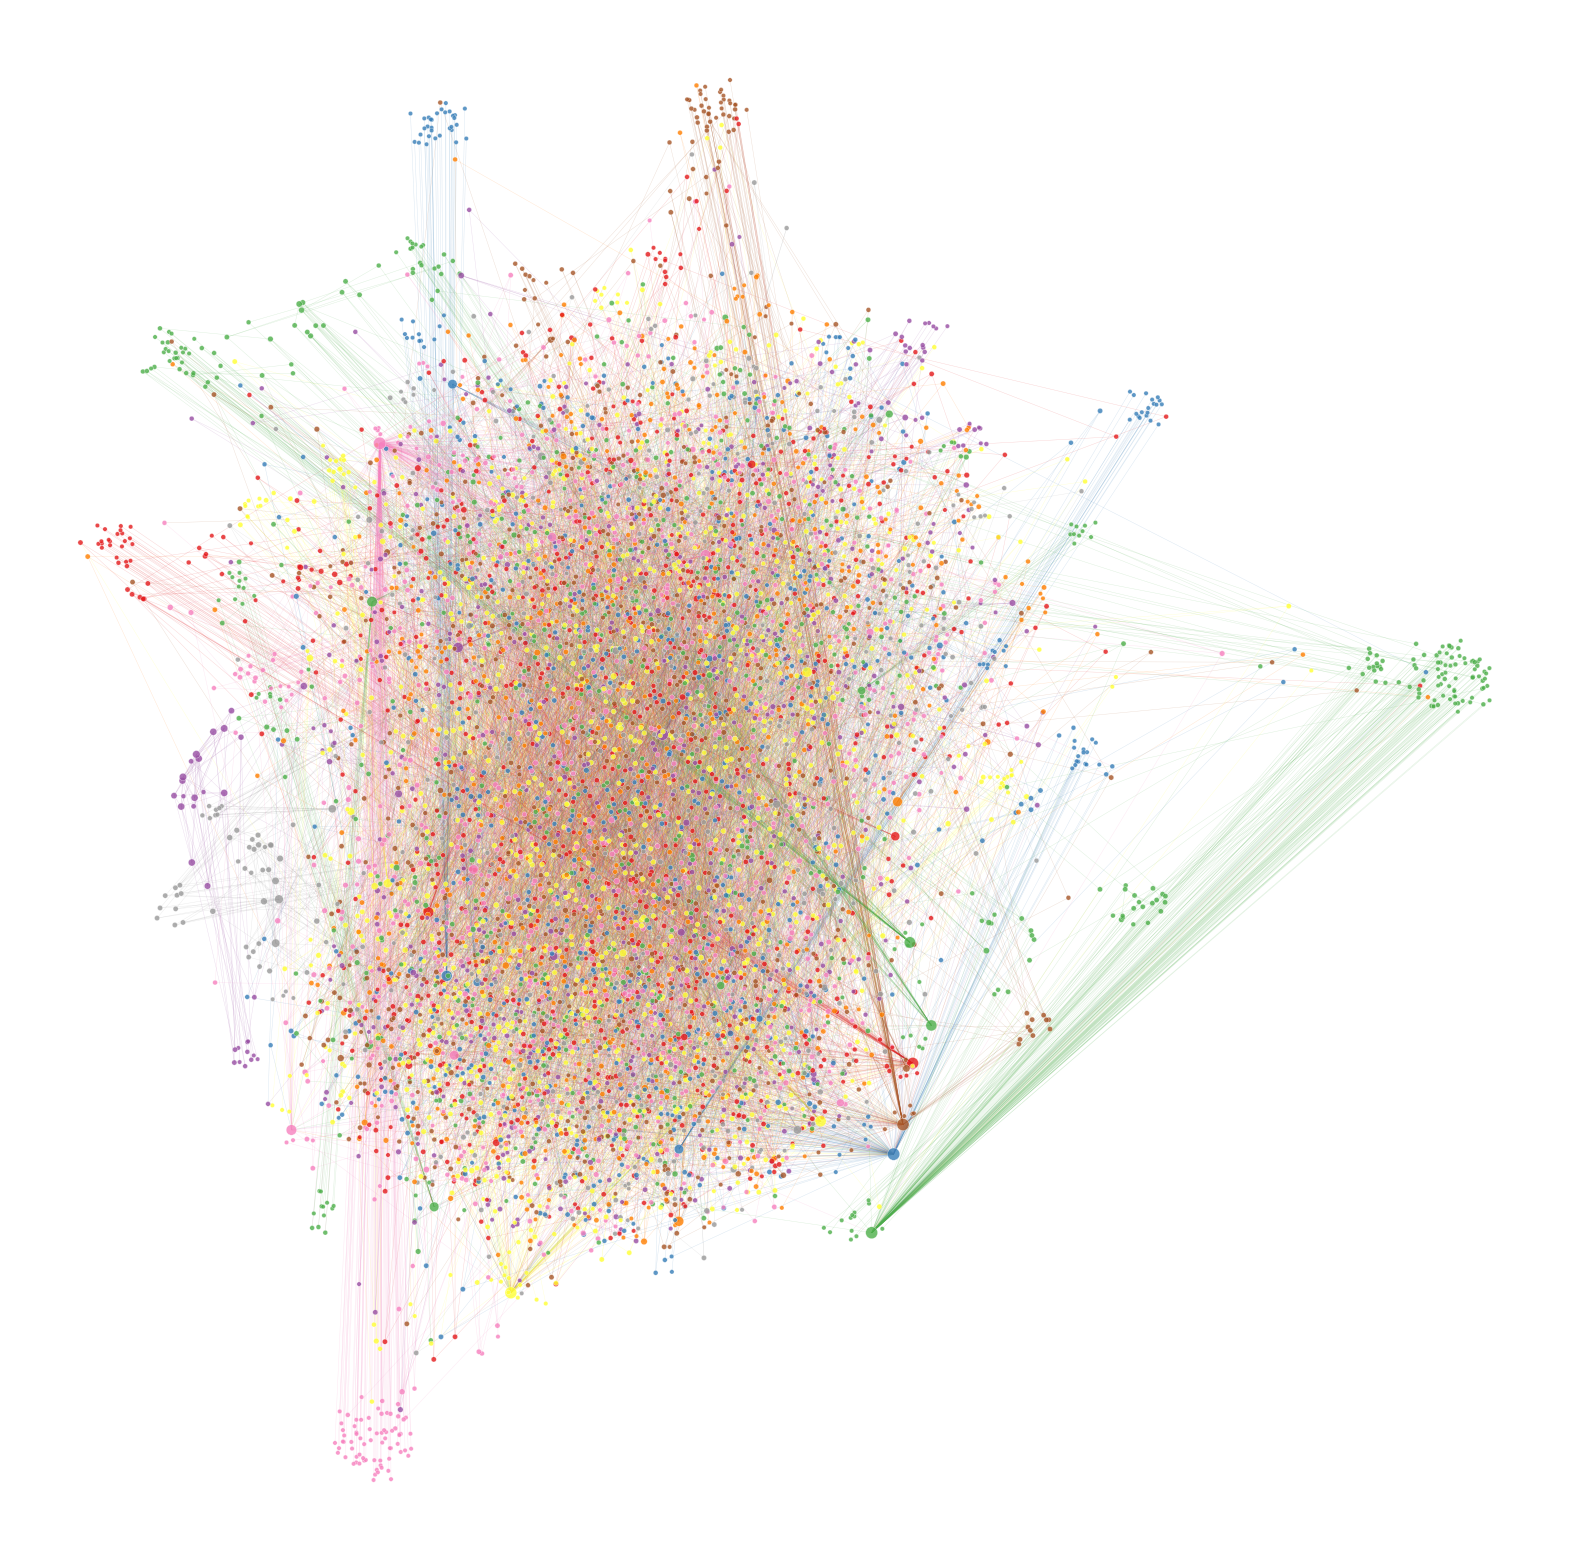

In [67]:
from graspologic.plot import networkplot

currtime = time.time()

# this is optional, may not need depending on the number of edges you have
sub_adj = subsample_edges(adj, 100_000)

# ax = networkplot(
#     sub_adj,
#     x="x",
#     y="y",
#     node_data=node_df,
#     node_size="rank_strength",
#     node_sizes=(10, 80),
#     figsize=(20, 20),
#     node_hue="community",
#     edge_linewidth=0.3,
#     palette=palette,
# )

ax = networkplot(
    sub_adj,
    x="x",
    y="y",
    node_data=node_df,
    node_size="rank_strength",
    node_sizes=(10, 80),
    figsize=(20, 20),
    node_hue="community",
    edge_linewidth=0.3,
)

ax.axis("off")

print(f"{time.time() - currtime:.3f} seconds elapsed.")